In [1]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
# set up a linear fit
def linear(x, *p):
    a, b = p
    return a*x + b

def sinusoid(x, *p):
    a, b, c, d = p
    return a * np.cos(b*x-c) + d

def sinusoid_deriv(x, *p):
    a, b, c, d = p
    return -a * b * np.sin(b*x-c)

def expoential(x, *p):
    a, b, c = p
    return 

def chi_squared(x, fit, sig):
     return np.sum(np.square(x-fit)/np.square(sig))

def reduced_chi_squared(x, fit, sig, N, n):
    return chi_squared(x, fit, sig)/(N-n)

In [3]:
# find the +- chi squared values for fit params
def fit_param_uncerts(fit_function, fit_params, x_vals, y_vals, uncerts):
    orig_chi = chi_squared(y_vals, fit_function(x_vals, *fit_params), uncerts)
    print('chi '+ str(orig_chi))
    print('dof ' + str(len(x_vals)-len(fit_params)))
    print('reduced ' + str(orig_chi/(len(x_vals)-len(fit_params))))
    out_params=list()
    for i in range(len(fit_params)):
        param=fit_params[i]
        change_change=abs(param*10)
        test_change=abs(param/10)
        avg_change=10 #placeholder
        last_avg_change=1000
        while abs(avg_change -1) > .01:
            fit_params_up=fit_params.copy()
            fit_params_down=fit_params.copy()
            fit_params_up[i]=fit_params[i]+test_change
            fit_params_down[i]=fit_params[i]-test_change

            #find chi squareds
            up_chi = chi_squared(y_vals, fit_function(x_vals, *fit_params_up), uncerts)
            down_chi = chi_squared(y_vals, fit_function(x_vals, *fit_params_down), uncerts)
            avg_change = (up_chi+down_chi-2*orig_chi)/2
            
           # print('Got avg change {} with test change {} and change change {} on param {}'.format(avg_change, test_change, change_change, param))
            
            #update for next run
            if avg_change > 1:
                test_change = min(abs(test_change-change_change), test_change)
            else:
                test_change = abs(test_change+change_change)
            if last_avg_change-1<0 != avg_change-1==0:
                change_change = min(change_change/(2), test_change/10)
            else:
                change_change = min(change_change*2, test_change/10)
                
        out_params.append(test_change)
    return out_params

Calibrate the strain gauge to position with linear fit

In [4]:
# get the data
strain= pd.read_table('/home/kal/jLab/optical_trapping/stain_calib.csv', delimiter=',')
strain.head()

,x_pos,x_pos_uncert,x_strain,x_strain_uncert,y_pos,y_pos_uncert,y_strain,y_strain_uncert
0,10.243,0.001,5.120,0.001,10.211,0.002,5.104,0.001
1,10.382,0.002,5.190,0.001,10.401,0.002,5.200,0.001
2,10.770,0.001,5.384,0.001,10.948,0.001,5.474,0.001
3,11.002,0.001,5.501,0.001,11.012,0.001,5.505,0.001
4,9.996,0.001,4.998,0.001,9.996,0.001,4.998,0.001


chi 7.288228117617149
dof 5
reduced 1.4576456235234299


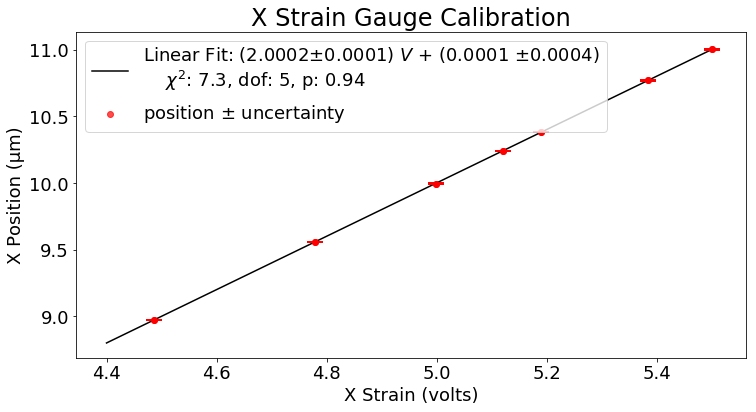

In [5]:
#do linear fits
p0 = [2,0]
popt, pcov = curve_fit(linear, strain['x_strain'], strain['x_pos'], p0=p0, sigma=strain['x_pos_uncert'])
param_errors = fit_param_uncerts(linear, popt, strain['x_strain'], strain['x_pos'], strain['x_pos_uncert'])

# make a plot
# plot the curve fit
test_points =np.linspace(4.4, 5.5, 100)
fig, ax = plt.subplots(1, figsize=(12, 6))

x_fit_label = 'Linear Fit: ({0:1.4f}$ \pm ${2:.4f}) $V$ + ({1:1.4f} $ \pm ${3:.4f})'.format(*popt, *param_errors) 
x_fit_label  = x_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(7.288228117617149, 5, 0.94)

# plot the points
ax.plot(test_points, linear(test_points, *popt), 'k', label=x_fit_label)
ax.scatter(strain['x_strain'], strain['x_pos'], c='red', alpha=0.7, label='position $ \pm $ uncertainty')
ax.errorbar(strain['x_strain'], strain['x_pos'], yerr=strain['x_pos_uncert'], fmt='.', c='red', ecolor='red', capsize=8, elinewidth=1, markeredgewidth=2, ms=10, label=None)
ax.set_ylabel('X Position (' + u'\u03bc' + 'm)')
ax.set_xlabel('X Strain (volts)')
plt.legend(fontsize=18)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.set_title('X Strain Gauge Calibration')
ax.title.set_fontsize(24)
plt.show()  

chi 6.258919949463069
dof 5
reduced 1.2517839898926137


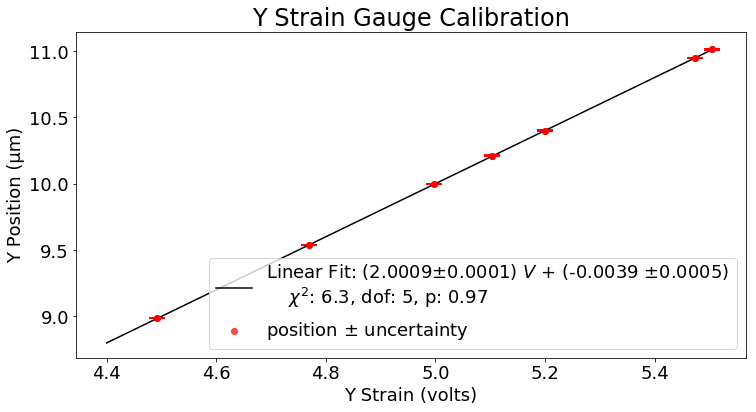

In [6]:
  #do linear fits
p0 = [2,0]
popt, pcov = curve_fit(linear, strain['y_strain'], strain['y_pos'], p0=p0, sigma=strain['y_pos_uncert'])
param_errors = fit_param_uncerts(linear, popt, strain['y_strain'], strain['y_pos'], strain['y_pos_uncert'])

# make a plot
# plot the curve fit
test_points =np.linspace(4.4, 5.5, 100)
fig, ax = plt.subplots(1, figsize=(12, 6))

y_fit_label = 'Linear Fit: ({0:1.4f}$ \pm ${2:.4f}) $V$ + ({1:1.4f} $ \pm ${3:.4f})'.format(*popt, *param_errors) 
y_fit_label  = y_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(6.258919949463069, 5, 0.97)

# plot the points
ax.plot(test_points, linear(test_points, *popt), 'k', label=y_fit_label)
ax.scatter(strain['y_strain'], strain['y_pos'], c='red', alpha=0.7, label='position $ \pm $ uncertainty')
ax.errorbar(strain['y_strain'], strain['y_pos'], yerr=strain['y_pos_uncert'], fmt='.', c='red', ecolor='red', capsize=8, elinewidth=1, markeredgewidth=2, ms=10, label=None)
ax.set_ylabel('Y Position (' + u'\u03bc' + 'm)')
ax.set_xlabel('Y Strain (volts)')
plt.legend(fontsize=18)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.set_title('Y Strain Gauge Calibration')
ax.title.set_fontsize(24)
plt.show()  

Calibrate the QPD voltage to position conversion with fixed bead

In [73]:
calib = pd.read_table('/home/kal/jLab/optical_trapping/calibration_data/calib_20181031_1um1000Knacl_250.1fullx.txt', delimiter='\t', header=None)
calib.columns = 'x_volts y_volts x_strain y_strain'.split()

num_bins=2000

strain_data = calib['x_strain']
qpd_data = calib['x_volts']
# set up the bin sizes
bins = np.linspace(min(strain_data), max(strain_data), num_bins)
bin_means = np.asarray(bins + (min(strain_data)-max(strain_data))/(2*num_bins))[:-1]
# bin the data
digitized = np.digitize(strain_data, bins)
qpd_means = [np.mean(qpd_data[digitized == i]) for i in range(1, len(bins))]
qpd_errors = [scipy.stats.sem(qpd_data[digitized == i]) for i in range(1, len(bins))]

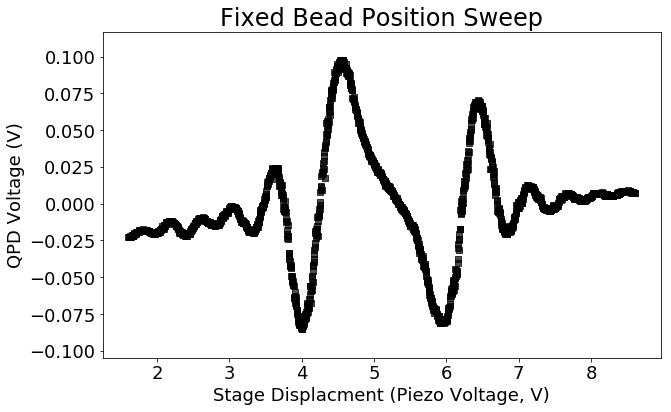

In [76]:
# plot the origonal and binned
bbox = dict(boxstyle="round", fc="0.95")

fig, ax = plt.subplots(1, figsize=(10, 6))

# plot the points
ax.scatter(bin_means, qpd_means, c='k', marker=',', alpha=0.7)
#ax.errorbar(bin_means[0::100], qpd_means[0::100], yerr=qpd_errors[0::100], fmt='.', c='red', ecolor='red', capsize=5, elinewidth=2, markeredgewidth=2, ms=10)

# add labesl
ax.set_title('Fixed Bead Position Sweep')
ax.set_xlabel('Stage Displacment (Piezo Voltage, V)')
ax.set_ylabel('QPD Voltage (V)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

In [77]:
# get the data for calibration
# data tables have the following format:
# first column [0] is stage x strain gauge voltage
# second column [1] is stage y strain gauge voltage
# third column [2] is QPD x voltage
# fourth column [3] is QPD y voltage

# calibration

file_path = '/home/kal/jLab/optical_trapping/calibration_data/'
file_names = [f for f in os.listdir(file_path) if not 'Settings' in f]
file_names = [f for f in file_names if not 'full' in f]

xys = [0 if f.split('.')[-2][-1] == 'x' else 1 for f in file_names]
xys = np.asarray(xys).flatten()
# test one out

file_name = os.path.join(file_path, file_names[0])
calib = pd.read_table(file_name, delimiter='\t', header=None)
calib.columns = 'x_volts y_volts x_strain y_strain'.split()
calib.head()

,x_volts,y_volts,x_strain,y_strain
0,0.000879,-0.002735,4.23744,5.08805
1,0.000550,-0.002735,4.23613,5.08772
2,0.000879,-0.002407,4.23514,5.08706
3,0.000879,-0.002407,4.23448,5.08706
4,0.000879,-0.003064,4.23317,5.08641


  0%|          | 0/21 [00:00<?, ?it/s]

calib_20181031_1um1000Knacl_100.1x.txt


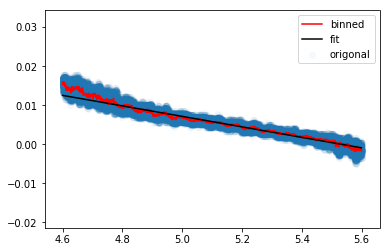

chi 1586.0034336954373
dof 1997
reduced 0.7941930063572545


  5%|▍         | 1/21 [00:05<01:59,  5.99s/it]

calib_20181031_1um1000Knacl_100.1y.txt


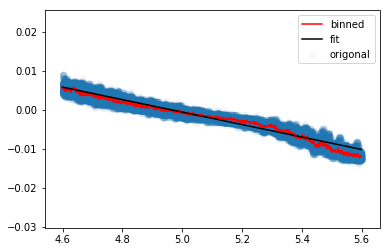

 10%|▉         | 2/21 [00:15<02:14,  7.11s/it]

chi 3747.6286518696916
dof 1997
reduced 1.8766292698396052
calib_20181031_1um1000Knacl_149.9x.txt


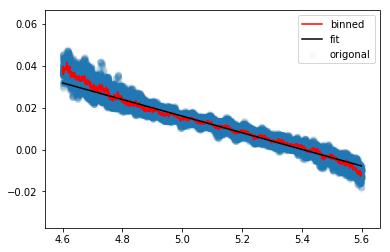

 14%|█▍        | 3/21 [00:22<02:07,  7.10s/it]

chi 1546.386193285652
dof 1997
reduced 0.7743546285857046
calib_20181031_1um1000Knacl_149.9y.txt


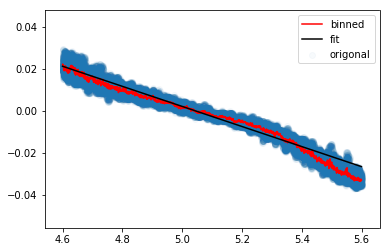

chi 4547.510418730179
dof 1997
reduced 2.27717096581381


 19%|█▉        | 4/21 [00:28<01:55,  6.78s/it]

calib_20181031_1um1000Knacl_200.2x.txt


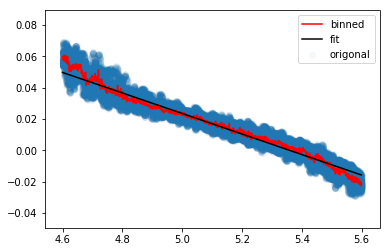

 24%|██▍       | 5/21 [00:35<01:50,  6.88s/it]

chi 1312.5736780180946
dof 1997
reduced 0.6572727481312441
calib_20181031_1um1000Knacl_200.2y.txt


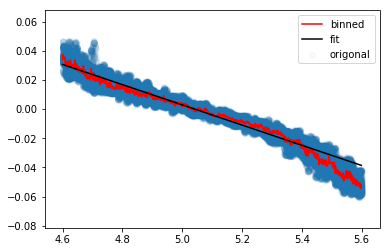

chi 3108.9988674822107
dof 1997
reduced 1.55683468576976


 29%|██▊       | 6/21 [00:41<01:38,  6.54s/it]

calib_20181031_1um1000Knacl_250.1x.txt


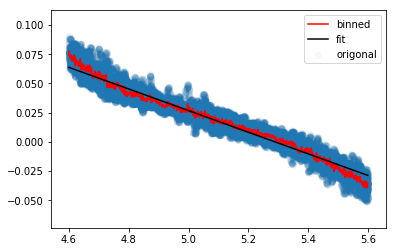

 33%|███▎      | 7/21 [00:48<01:32,  6.62s/it]

chi 1286.7893591189177
dof 1997
reduced 0.6443612213915462
calib_20181031_1um1000Knacl_250.1y.txt


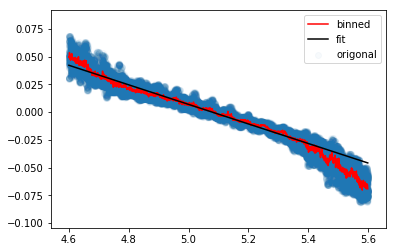

 38%|███▊      | 8/21 [00:54<01:25,  6.59s/it]

chi 2445.2395365079724
dof 1997
reduced 1.2244564529333863
calib_20181031_1um1000Knacl_299.9x.txt


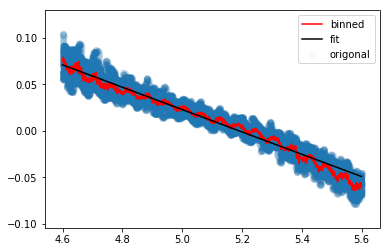

 43%|████▎     | 9/21 [01:00<01:14,  6.24s/it]

chi 1843.8662584871702
dof 1997
reduced 0.9233181064031899
calib_20181031_1um1000Knacl_299.9y.txt


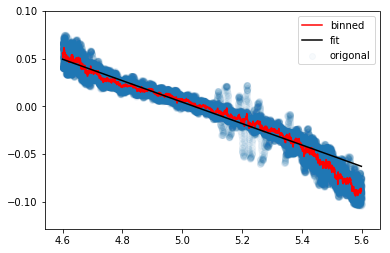

 48%|████▊     | 10/21 [01:05<01:06,  6.00s/it]

chi 3737.392102960356
dof 1997
reduced 1.8715033064398379
calib_20181031_1um1000Knacl_350.0x.txt


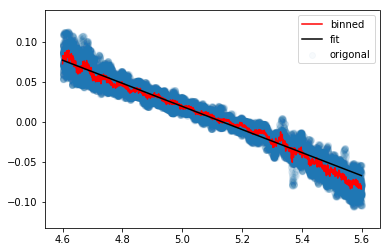

 52%|█████▏    | 11/21 [01:11<00:58,  5.86s/it]

chi 1343.0663839511285
dof 1997
reduced 0.6725420049830388
calib_20181031_1um1000Knacl_350.0y.txt


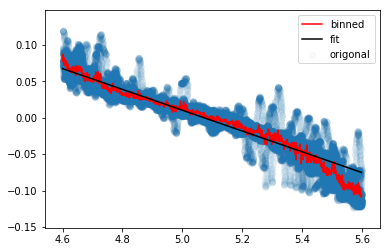

 57%|█████▋    | 12/21 [01:16<00:50,  5.64s/it]

chi 1997.4148047543504
dof 1997
reduced 1.0002077139480974
calib_20181031_1um1000Knacl_400.3x.txt


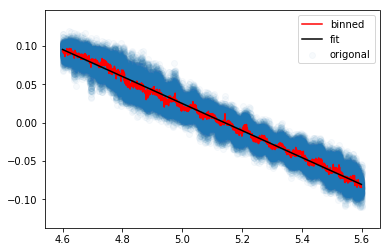

 62%|██████▏   | 13/21 [01:21<00:43,  5.43s/it]

chi 397.70695919168463
dof 1997
reduced 0.19915220790770388
calib_20181031_1um1000Knacl_400.3y.txt


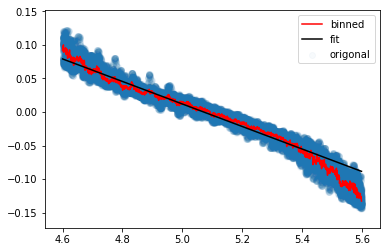

 67%|██████▋   | 14/21 [01:26<00:37,  5.29s/it]

chi 3064.5432723356253
dof 1997
reduced 1.5345734964124313
calib_20181031_1um1000Knacl_450.4x.txt


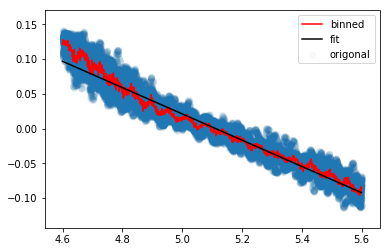

 71%|███████▏  | 15/21 [01:31<00:31,  5.22s/it]

chi 1829.138627950069
dof 1997
reduced 0.9159432288182618
calib_20181031_1um1000Knacl_450.4y.txt


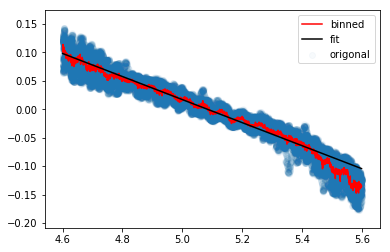

 76%|███████▌  | 16/21 [01:36<00:25,  5.15s/it]

chi 1450.1054119150806
dof 1997
reduced 0.726141918835794
calib_20181031_1um1000Knacl_495.3x.bmp


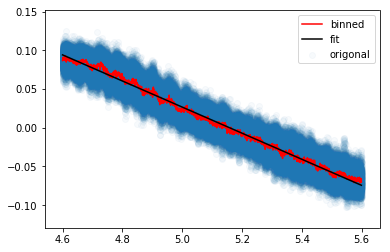

 81%|████████  | 17/21 [01:44<00:24,  6.01s/it]

chi 492.8045550487449
dof 1997
reduced 0.2467724361786404
calib_20181031_1um1000Knacl_495.3x.txt


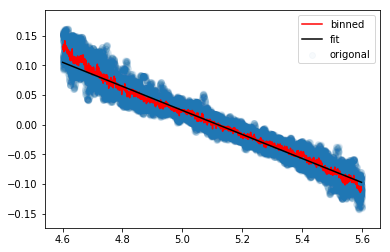

 86%|████████▌ | 18/21 [01:49<00:16,  5.65s/it]

chi 675.9184216698741
dof 1997
reduced 0.33846691120173966
calib_20181031_1um1000Knacl_495.3y.txt


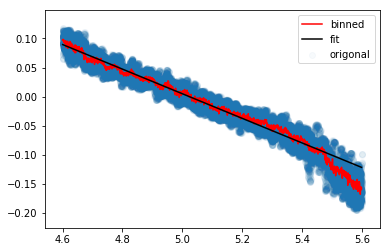

 90%|█████████ | 19/21 [01:54<00:10,  5.47s/it]

chi 1500.9337366851669
dof 1997
reduced 0.7515942597321817
calib_20181031_1um1000Knacl_75.7x.txt


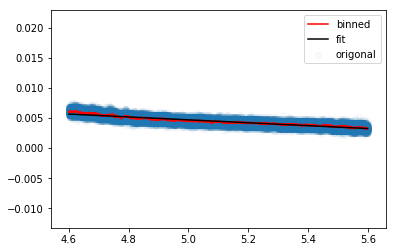

 95%|█████████▌| 20/21 [01:59<00:05,  5.36s/it]

chi 531.944296508141
dof 1997
reduced 0.2663717058127897
calib_20181031_1um1000Knacl_75.7y.txt


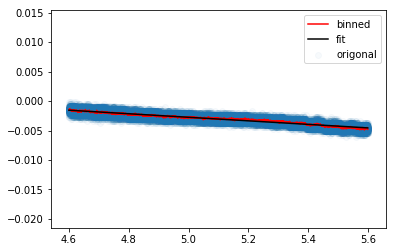

100%|██████████| 21/21 [02:04<00:00,  5.17s/it]

chi 422.59216401868827
dof 1997
reduced 0.21161350226273823


In [78]:
# bin to get errors
voltages= list()
slopes=list()
intercepts=list()
slope_errors=list()
intercept_errors=list()
num_bins=2000
low_cut=4.6
high_cut=5.6
mid = (high_cut+low_cut)/2
diff = (high_cut-low_cut)/2

for file_name in tqdm(file_names):
    print(file_name)
    calib = pd.read_table(os.path.join(file_path, file_name), delimiter='\t', header=None)
    calib.columns = 'x_volts y_volts x_strain y_strain'.split()

    # get specific dataset
    voltage = file_name.split('_')[-1].split('x')[0].split('y')[0]
    if file_name.split('.')[-2][-1] == 'x':
        strain_data = calib[(abs(calib['x_strain'] - mid) <diff)]['x_strain']
        qpd_data = calib[(abs(calib['x_strain'] - mid) <diff)]['x_volts']
    else:
        strain_data = calib[(abs(calib['y_strain'] - mid) <diff)]['y_strain']
        qpd_data = calib[(abs(calib['y_strain'] - mid) <diff)]['y_volts']

    # set up the bin sizes
    bins = np.linspace(min(strain_data), max(strain_data), num_bins)
    bin_means = np.asarray(bins + (min(strain_data)-max(strain_data))/(2*num_bins))[:-1]

    # bin the data
    digitized = np.digitize(strain_data, bins)

    qpd_means = [np.mean(qpd_data[digitized == i]) for i in range(1, len(bins))]
    qpd_errors = [scipy.stats.sem(qpd_data[digitized == i])*5 for i in range(1, len(bins))]

    # plot the origonal and binned
    plt.scatter(strain_data, qpd_data, label='origonal', alpha=0.03)
    plt.plot(bin_means, qpd_means, 'r', label='binned')

    # curve fit
    # p0 is the initial guess for the fitting coefficients
    p0 = [-10, 10]
    popt, pcov = curve_fit(linear, bin_means, qpd_means, p0=p0, sigma=qpd_errors)
    # plot the curve fit
    plt.plot(bin_means, linear(bin_means, *popt), 'k', label='fit')
    plt.legend()
    plt.show()
    
    param_errors = fit_param_uncerts(linear, popt, bin_means, qpd_means, qpd_errors)
    slope_errors.append(param_errors[0])
    intercept_errors.append(param_errors[1])    

    # add to the lists of params
    voltages.append(voltage)
    slopes.append(popt[0])
    intercepts.append(popt[1])

In [79]:
# fit the qpd-distancec at differnet voltages
# we give it strain, it gives out a qpd
# so slope is 1/slpe and int is - int for other way
# to get conversion in actual distance, not strain, we divide by 2
calibrations = pd.DataFrame({'voltage':[float(v) for v in voltages], 'intercept':intercepts, 'slope':[s/2 for s in slopes], 'xy':xys, 'serr':[400*s for s in slope_errors], 'ierr':intercept_errors})
calibrations.head()

,ierr,intercept,serr,slope,voltage,xy
0,0.000011,0.074297,0.001041,-0.006714,100.1,0
1,0.000012,0.079147,0.001135,-0.007977,100.1,1
2,0.000031,0.213976,0.002388,-0.019806,149.9,0
3,0.000032,0.241610,0.002547,-0.023946,149.9,1
4,0.000053,0.350963,0.005075,-0.032746,200.2,0


In [80]:
# fit the qpd-distancec at differnet voltages
# we give it qpd, it gives out a strain
# so slope is 1/slpe and int is - int
p0=[10, 0]
y_calib, pcov = curve_fit(linear, calibrations[calibrations['xy'] == 1]['voltage'], calibrations[calibrations['xy'] == 1]['slope'], sigma=calibrations[calibrations['xy'] == 1]['serr'], p0=p0)
x_calib, pcov = curve_fit(linear, calibrations[calibrations['xy'] == 0]['voltage'], calibrations[calibrations['xy'] == 0]['slope'], sigma=calibrations[calibrations['xy'] == 0]['serr'], p0=p0)

x_calib_errors = fit_param_uncerts(linear, x_calib,calibrations[calibrations['xy'] == 0]['voltage'], calibrations[calibrations['xy'] == 0]['slope'], calibrations[calibrations['xy'] == 0]['serr'])
y_calib_errors = fit_param_uncerts(linear, x_calib,calibrations[calibrations['xy'] == 1]['voltage'], calibrations[calibrations['xy'] == 1]['slope'], calibrations[calibrations['xy'] == 1]['serr'])

chi 4.123570695442251
dof 9
reduced 0.4581745217158057
chi 6.135741006407316
dof 8
reduced 0.7669676258009145


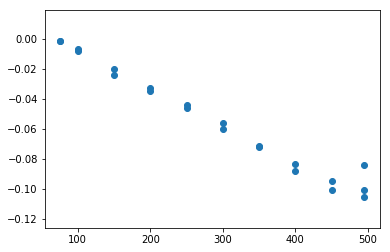

In [81]:
plt.scatter(calibrations['voltage'], calibrations['slope'])
plt.show()

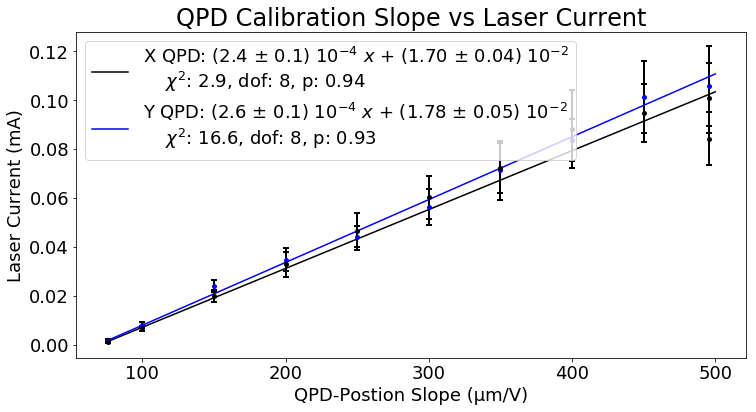

In [94]:
# plot the points
fig, ax = plt.subplots(1, figsize=(12, 6))


#x_fit_label = 'Linear Fit: ({0:1.5f}$ \pm ${2:.5f}) $I$ + ({1:1.5f} $ \pm ${3:.5f})'.format(*x_calib, *x_calib_errors) 
#x_fit_label  = x_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(2.89173, 8, 0.94)

#y_fit_label = 'Linear Fit: ({0:1.5f}$ \pm ${2:.5f}) $I$ + ({1:1.5f} $ \pm ${3:.5f})'.format(*y_calib, *y_calib_errors) 
#y_fit_label  = y_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(16.62, 8, 0.034)

x_fit_label = 'X QPD: (2.4 $ \pm $ 0.1) $10^{-4}$ $x$ + (1.70 $ \pm $ 0.04) $10^{-2}$' 
x_fit_label  = x_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(2.89173, 8, 0.94)

y_fit_label = 'Y QPD: (2.6 $ \pm $ 0.1) $10^{-4}$ $x$ + (1.78 $ \pm $ 0.05) $10^{-2}$' 
y_fit_label  = y_fit_label + '\n    $\chi ^2$: {:.1f}, dof: {}, p: {:.2f}'.format(16.62, 8, 0.934)

# add labesl
ax.set_title('QPD Calibration Slope vs Laser Current')
ax.set_xlabel('QPD-Postion Slope (' +u'\u03bc'+'m/V)')
ax.set_ylabel('Laser Current (mA)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

ax.errorbar(calibrations[calibrations['xy'] == 1]['voltage'], -calibrations[calibrations['xy'] == 1]['slope'], yerr=calibrations[calibrations['xy'] == 1]['serr'], 
            c='b', fmt='.', capsize=3, elinewidth=2, markeredgewidth=2, ecolor='black', label=None)
ax.errorbar(calibrations[calibrations['xy'] == 0]['voltage'], -calibrations[calibrations['xy'] == 0]['slope'], yerr=calibrations[calibrations['xy'] == 0]['serr'], 
            c='k', fmt='.', capsize=3, elinewidth=2, markeredgewidth=2, ecolor='black', label=None)

test_calibs = np.linspace(75, 500, 1000)
ax.plot(test_calibs, -linear(test_calibs, *x_calib), c='k', label=x_fit_label)
ax.plot(test_calibs, -linear(test_calibs, *y_calib), c='b', label=y_fit_label)

plt.legend(fontsize=18)


for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)



In [83]:
# do the trap stiffness as a function of voltage

file_path = '/home/kal/jLab/optical_trapping/equipartition_data/'
file_names = [f for f in os.listdir(file_path) if not 'Settings' in f]
print(file_names)

['psd_20181105_1um1000Kdi_100.3.txt', 'psd_20181105_1um1000Kdi_100.8.txt', 'psd_20181105_1um1000Kdi_149.8.txt', 'psd_20181105_1um1000Kdi_150.3.txt', 'psd_20181105_1um1000Kdi_199.9.txt', 'psd_20181105_1um1000Kdi_200.1.txt', 'psd_20181105_1um1000Kdi_250.0.txt', 'psd_20181105_1um1000Kdi_250.2.txt', 'psd_20181105_1um1000Kdi_299.4.txt', 'psd_20181105_1um1000Kdi_300.8.txt', 'psd_20181105_1um1000Kdi_350.6.txt', 'psd_20181105_1um1000Kdi_350.8.txt', 'psd_20181105_1um1000Kdi_400.1.txt', 'psd_20181105_1um1000Kdi_400.3.txt', 'psd_20181105_1um1000Kdi_450.1.txt', 'psd_20181105_1um1000Kdi_450.2.txt', 'psd_20181105_1um1000Kdi_495.4.txt', 'psd_20181105_1um1000Kdi_496.5.txt']


In [84]:
# bin to get errors
voltages = list()
variences = list()
var_error=list()
stage_var=list()

for file_name in tqdm(file_names):
    eqip = pd.read_table(os.path.join(file_path, file_name), delimiter='\t', header=None)
    eqip.columns = 'x_volts y_volts x_strain y_strain'.split()
    
    # get specific dataset
    voltage = float(file_name.split('_')[-1].split('.txt')[0])
    # calibrated slope at this voltage
    x_slope = linear(voltage, *x_calib)
    x_slope_up = linear(voltage, x_calib[0]+x_calib_errors[0], x_calib[1])
    x_slope_down = linear(voltage, x_calib[0]-x_calib_errors[0], x_calib[1])
    y_slope = linear(voltage,  *y_calib)
    y_slope_up = linear(voltage, y_calib[0]+y_calib_errors[0], y_calib[1])
    y_slope_down = linear(voltage, y_calib[0]-y_calib_errors[0], y_calib[1])
    
    # get the r values in strain units
    rs=list()
    rs_up=list()
    rs_down=list()
    rs.append(1/x_slope*(eqip['x_volts']-np.average(eqip['x_volts'])))
    rs.append(1/y_slope*(eqip['y_volts']-np.average(eqip['y_volts'])))
    rs_up.append(1/x_slope_up*(eqip['x_volts']-np.average(eqip['x_volts'])))
    rs_up.append(1/y_slope_up*(eqip['y_volts']-np.average(eqip['y_volts'])))
    rs_down.append(1/x_slope_down*(eqip['x_volts']-np.average(eqip['x_volts'])))
    rs_down.append(1/y_slope_down*(eqip['y_volts']-np.average(eqip['y_volts'])))
    rs = np.asarray(rs).flatten()
    rs_down = np.asarray(rs_down).flatten()
    rs_up = np.asarray(rs_up).flatten()
  
    #get the varience
    variences.append(np.var(rs))
    # get the voltage
    voltages.append(float(voltage))
    
    # error from varience in slope
    var_error.append((np.var(rs_up)-np.var(rs_down))/2)
    
    # varience in stage position
    stage_var.append((np.var(eqip['x_strain']) + np.var(eqip['y_strain']))/2)

100%|██████████| 18/18 [00:05<00:00,  3.12it/s]


In [85]:
print(variences[:10])
print(len(var_error))
print(var_error[:10])
print((np.asarray(var_error)/np.asarray(variences))[:10])

[1.554854093554815, 1.788630828698049, 0.275703359354711, 0.8864657787575378, 0.18227207557156494, 0.38845696635766386, 0.17290964052719193, 0.2504638375820699, 0.12180687181894868, 0.1513960605755872]
18
[0.20394297977189857, 0.2291804974673306, 0.02043591142212478, 0.0645454702501776, 0.011145348136308408, 0.02325718002649696, 0.009603293811266178, 0.013721772056882395, 0.006289473849515517, 0.007558673766223531]
[0.13116535 0.12813181 0.07412282 0.07281214 0.06114677 0.05987067
 0.05553938 0.05478544 0.0516348  0.04992649]


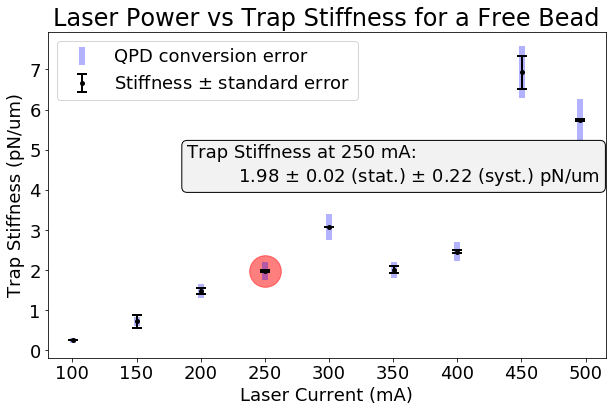

[0.00196762]


In [99]:
# error in stiffness from varience in slope? 

#.42 is kbt approximation

# set up the combined data sizes
new_vars=np.average(np.asarray(variences).reshape(-1, 2), axis=1)
#propegating error for claculation with kbt devision
new_var_error= .42/new_vars * (np.average(np.asarray(var_error).reshape(-1, 2), axis=1))/new_vars *2
#error from std error
var_error_2=.42/new_vars * (np.var(np.asarray(variences).reshape(-1, 2), axis=1)/np.sqrt(2))/new_vars *2

new_voltages=np.average(np.asarray(voltages).reshape(-1, 2), axis=1)
new_stage_var = np.average(np.asarray(stage_var).reshape(-1, 2), axis=1)


fig, ax = plt.subplots(1, figsize=(10, 6))

# add labels
ax.set_title('Laser Power vs Trap Stiffness for a Free Bead')
ax.set_xlabel('Laser Current (mA)')
ax.set_ylabel('Trap Stiffness (pN/um)')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)
ax.title.set_fontsize(24)

#ax.errorbar(new_voltages, .42/new_vars, yerr=var_error_new, fmt='.', capsize=0, elinewidth=6, markeredgewidth=2, ecolor='blue', alpha=0.3)
#ax.errorbar(new_voltages, .42/new_vars, yerr=var_error_2, fmt='.', capsize=5, elinewidth=2, markeredgewidth=2, ecolor='black')

ax.errorbar(new_voltages, .42/new_vars, yerr=new_var_error, fmt='none', capsize=0, elinewidth=6, markeredgewidth=2, ecolor='blue', alpha=0.3, label='QPD conversion error')
ax.errorbar(new_voltages, .42/new_vars, yerr=var_error_2, fmt='k.', capsize=5, elinewidth=2, markeredgewidth=2, ecolor='black', label='Stiffness $\pm$ standard error')


plt.scatter(250, .42/new_vars[3], marker='o', s=1000, c='r', alpha=0.5)


ax.annotate('Trap Stiffness at 250 mA: \n\t {:.2f} '.format(.42/new_vars[3]) + r'$ \pm $' + ' {:.2f} (stat.) '.format(var_error_2[3]) + r'$ \pm $' + ' {:.2f} (syst.) pN/um'.format(new_var_error[3]), 
            xy=(.25, .65), xycoords='axes fraction',
            size=18, ha='left', va='top', bbox=bbox)
plt.legend(fontsize=18)
plt.show()

print(np.sqrt(new_stage_var[[abs(v-250)<5 for v in new_voltages]]))

In [19]:
# get the stokes drag
file_path = '/home/kal/jLab/optical_trapping/stokes_data/'
file_names = [f for f in os.listdir(file_path) if not 'Settings' in f]
#file_names = [file_names[0]]
print(file_names)
print(len(file_names))

['stokes_20181105_1um1000Kdi_.5_3_x.txt', 'stokes_20181105_1um1000Kdi_.5_3_y.txt', 'stokes_20181105_1um1000Kdi_.5_5_x.txt', 'stokes_20181105_1um1000Kdi_.5_5_y.txt', 'stokes_20181105_1um1000Kdi_1_3_x.txt', 'stokes_20181105_1um1000Kdi_1_3_y.txt', 'stokes_20181105_1um1000Kdi_1_5_x.txt', 'stokes_20181105_1um1000Kdi_1_5_y.txt', 'stokes_20181105_1um1000Kdi_2_3_x.txt', 'stokes_20181105_1um1000Kdi_2_3_y.txt', 'stokes_20181105_1um1000Kdi_2_5_x.txt', 'stokes_20181105_1um1000Kdi_2_5_y.txt']
12


In [68]:
velocity = list()
strain_disp=list()
betas=list()
avg_v = list()

for file_name in file_names:
    print(file_name)
    stokes = pd.read_table(os.path.join(file_path, file_name), delimiter='\t', header=None)
    stokes.columns = 'x_volts y_volts x_strain y_strain'.split()
    
    # get the right data to work wtih
    voltage = 250
    if file_name.split('.txt')[0][-1] == 'x':
        position_data = 7*stokes['x_strain']
        qpd_data = stokes['x_volts']
    else:
        position_data = 3*stokes['y_strain']
        qpd_data = stokes['y_volts']
                
    # sample rate is 10000/second
    times = np.asarray(range(len(position_data)))/10000
    
    if file_name.split('_')[-2]=='5':
        p0 = [np.max(position_data)-np.average(position_data),-30, -np.amax(position_data[:5000]) ,  np.average(position_data)]
    else:
        p0 = [np.max(position_data)-np.average(position_data), -15, -np.amax(position_data[:5000]) ,  np.average(position_data)]
    #print(p0)
    #p0 = [ -0.29706306, -18.85507195, -15.65597457,  10.22249926]  
    # fit a sin to the stage motion
    # error form background vareince 
    
        # plot the origonal, fit and deriv
    #plt.scatter(times[:10000], position_data[:10000], label='origonal', alpha=0.03)
    #plt.plot(times[:10000], sinusoid(times, *p0)[:10000], 'g', alpha=0.5, label='guess fit')
    #plt.legend()
    #plt.show()
    
    popt, pcov = curve_fit(sinusoid, times[:5000], position_data[:5000], p0=p0, sigma=[0.02051139]*len(position_data[:5000]))
    #print(popt)
    #param_errors = fit_param_uncerts(sinusoid, popt, range(len(qpd_data)), qpd_data, [0.02051139]*len(qpd_data))
    
    # get the velocity
    vs = sinusoid_deriv(times, *popt)
    print(np.average(np.abs(vs)))
    avg_v.append(np.average(np.abs(vs)))
    #us = (np.asarray(position_data[5:])-np.asarray(position_data[:-5]))/.0002
    #print(np.average(np.abs(us)))
    #plt.plot(vs[:-5], us)
    #plt.show()

    
    # plot the origonal, fit and deriv
    #plt.scatter(times[:10000], position_data[:10000], label='origonal', alpha=0.03)
    #plt.plot(times[:10000], sinusoid(times, *popt)[:10000], 'r', label='position fit')
    #plt.plot(times[:10000], sinusoid(times, *p0)[:10000], 'g', alpha=0.5, label='guess fit')
    #plt.legend()
    #plt.show()
       

    # add to the lists of params
    #print(np.average(vs))
    velocity.append(np.var(vs))
    if file_name.split('.txt')[0][-1] == 'x':
        slope = linear(voltage, *x_calib)
    else:
        slope = linear(voltage, *y_calib)
    # get displacment, and make it zero average
    ds = (1/slope)*(qpd_data-np.average(qpd_data))
    strain_disp.append(np.var(ds))
    #print(np.average(ds))
    
    var_root = np.sqrt((np.var(ds))/(np.var(vs)))*.42/new_vars[3]
    betas.append(var_root)
    print(var_root)
    

stokes_20181105_1um1000Kdi_.5_3_x.txt
12.47709891086233
0.11353068091914752
stokes_20181105_1um1000Kdi_.5_3_y.txt
5.538712469107793
0.09148646065480322
stokes_20181105_1um1000Kdi_.5_5_x.txt
12.040519127994184
0.10697009844030222
stokes_20181105_1um1000Kdi_.5_5_y.txt
5.528621857827114
0.09048674569379553
stokes_20181105_1um1000Kdi_1_3_x.txt
25.522758075455002
0.06548704516101475
stokes_20181105_1um1000Kdi_1_3_y.txt
11.317056719514813
0.041953488055413
stokes_20181105_1um1000Kdi_1_5_x.txt
24.56809229412919
0.05886894346105144
stokes_20181105_1um1000Kdi_1_5_y.txt
11.02947554136911
0.09254978765697486
stokes_20181105_1um1000Kdi_2_3_x.txt
54.03952363138693
0.05038390080668349
stokes_20181105_1um1000Kdi_2_3_y.txt
24.252934497436318
0.031110502021009276
stokes_20181105_1um1000Kdi_2_5_x.txt
51.03899218070453
0.03182290703668408
stokes_20181105_1um1000Kdi_2_5_y.txt
22.893761101130227
0.02990902548491069


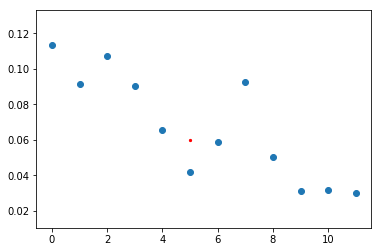

In [69]:
plt.scatter(range(len(betas)), betas)
plt.scatter(5, .0602, c='r', s=5)
plt.show()

In [70]:
print(np.average(betas))
print(np.sqrt(np.var(betas)/len(betas)))

0.06704663211598251
0.008514588184186876


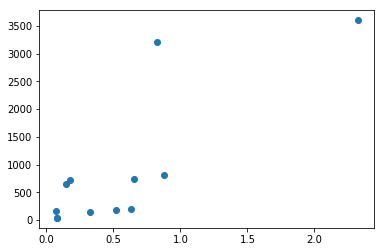

In [71]:
plt.scatter(strain_disp, velocity)
plt.show()

In [65]:
len(strain_disp)

12